# Auralizacaja - Symulacje odpowiedzi impulsowych
## 1. Wstęp

Celem dzisiejszych zajęć będzie zapoznanie się z różnymi metodami generowania odpowiedzi impulsowych pomeiszczeń na potrzeby auralizacji. Podstawą zajęć jest kod przygotowany w języku programowania Python. 

## 2. Ray Tracing
Podstawą dzisiejszych zajęć będzie algorytm wykorzystujący metodę promieniową do modelowania akustyki pomieszczenia. Cały algorytm podzielony jest na bloki, które wykonują różne akcje. Poszczególne bloki są opisane, aby ułatwić zrozumienie działania algorytmu.

Pierwszy blok kodu odpoiwada za importy wykorzystywanywch przez program bibliotek. Najważniejszą z punktu widzenia dzisiejszych zajęć jest biblioteka numpy. Zapewnia ona obsługę macierzy w sposób zbliżony do pakietu Matlab. Dokładne informacje o odpowiednikach komend i instukcji z języka Matlab dostępne są na stronie: https://docs.scipy.org/doc/numpy-1.15.0/user/numpy-for-matlab-users.html.

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets, IntProgress
#from IPython import display
import pandas as pd
import pickle
import cython

Następnie importowana jest biblioteka SimulationRT napisana na potrzeby dzisiejszych zajęć. Zawiera ona prosty algorytm śledzenia promieni. Pliki związane z tą biblioteką znajdują się w folderze simpleRT. Biblioteka ta wykorzystuje pakiet Cython, który pozwala na automatyczne tłumaczenie kodu napisanego w Pythonie na język C. Wykorzystanie biblioteki Cython pozwoliło na przyśpieszenie obliczeń około 1000-krotnie, kosztem przejrzystości i łatwości edycji kodu programu.

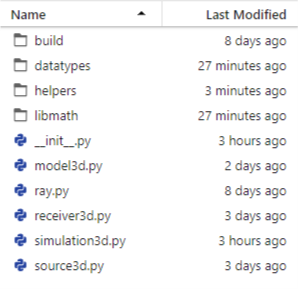

Po wczytaniu biblioteki tworzony jest podstawowy obiekt który będzie zawierał informacje o prowadzonych symulacjach - SimulationRT(). Obiekt ten przechowuje informacje o modelu, odbiornikach i nadajnikach oraz zawiera funkcie odpowiedzialne za wykonywanie obliczeń.

In [ ]:
#!python _CythonSetup.py build_ext --inplace    # Uncomment to build the library first
from simpleRT import SimulationRT
simulation = SimulationRT()

Kolejnym etapem jest wczytanie modelu, dla którego będą przeprowadzane obliczenia. Modele są importowane z popularnego formatu obj. Format ten przypomina sposób opisu geometrii w programie CATT-Acoustic. Na początku pliku znajdują się informacje o wierzchołkach modelu, następnie definicje normalnych powierzchni i na końcu powierzchnie utworzone z wierzchołków.

Po wczytaniu model jest przypisywany do symulacji.

In [ ]:
from simpleRT import Model3D
import os

folder = 'modele'
basename = 'korytarz'
filename = basename+'.obj'
model3D = Model3D()

os.chdir(folder)
model3D.loadOBJ(filename)
os.chdir('..')

simulation.model3d = model3D

Następne bloki kodu odpowiadają za wyświetlenie modelu sali i zadanie niektórych parametrów. Ich szczegółowa analiza nie jest konieczna, ponieważ odpowiadają one tylko za interakcję z użytkownikiem.

Prawy przycisk myszy przesuwa model, lewy przycisk obraca model, kółko przybliża i oddala.

UWAGA! W celu zatwierdzenia wprowadzanych wartości konieczne jest wciśnięcie klawisza enter!

In [ ]:
model_display_holder = widgets.Output(layout={'border': '1px solid black'})
model_display_holder

In [ ]:
from notebook_helpers.helpers import *
display_model(model_display_holder, model3D, simulation)

In [ ]:
from notebook_helpers.helpers import *

#### Create source, assign it to model, handle interactions with GUI
from simpleRT import Source3D
source = Source3D()
simulation.source = source

##### Create receiver, assign it to model, handle interactions with GUI
from simpleRT import Receiver3D
receiver = Receiver3D()
simulation.receiver = receiver

display_position_controls(simulation ,model3D, model_display_holder)

In [ ]:
### Create table with material absorption and diffusion coefficients, handle GUI interactions
from simpleRT.helpers import matloader as mat
import ipysheet as ip

mat_filename = os.path.join(folder,basename+'.mat')
try:
    model3D = mat.load_previous_materials(model3D, mat_filename)
except:
    print('Material file not found: %s' % s)
    pass
    
df = model3D.export_materials_as_dict()

sheet = ip.from_dataframe(df)
sheet

Ustal pozycje źródła i nadajnika zwryfikuj przyjęte wszpółczynniki pochłaniania i rozproszenia dźwięku. Po zadaniu parametrów modelu można przejść do wykonywania obliczeń. W poniższym bloku wykonywane są symulacje. Na początek uruchom symulacje z domyślnymi parametrami. 

Parametry:
 1. no_rays - liczba promieni
 2. fs - fs
 3. sim_length - dlugość symulacji
 4. max_reflection_order - określa liczbę odbić po której promień jest odrzucany,
 5. brute_force - zmienia sposób przeszukiwania geometrii, jeżeli wartość jest ustawiona na false wykorzystywane jest drzewo BVH do szybszego wykrywania przecięć (więcej informacji na wykładzie), 
 6. reflection_model - zmienia sposób modelowania odbicia dźwięku, dostępne opcje `ReflectionModel.Phong` i `ReflectionModel.Base` (więcej informacji na wykładach)
 7. intersection_model - zmienia sposób wykrywania przecięć promieni z modelem `RaySphereIntersection.Full` i `RaySphereIntersection.Simple`. W przypadku modelu Full uwzględniany jest czas propagacji promienia przez odbiornik, w przypadku modelu Simple uwzględniany jest tylko czas dotarcia do środka odbiornika. Korzystając z modelu simple nie jest konieczne wykrywanie maksimów na etapie auralizacji (więcej informacji na wykładach).

W czasie trwania obliczeń zapoznaj się z opisem działania algorytmu znajdującym się poniżej.

In [ ]:
from simpleRT import ReflectionModel, RaySphereIntersection

no_rays = 15000
fs = 44100
sim_length = 2
max_reflection_order = 40
brute_force = False
reflection_model = ReflectionModel.Phong
intersection_model = RaySphereIntersection.Full

# Update and optionaly save materials
updated_mat = ip.to_dataframe(sheet)
model3D.import_materials_from_dict(updated_mat)
#mat.save_materials(model3D, mat_filename)
    
# Define callback to display progress bar
global f
f = IntProgress(min=0, max=no_rays) # instantiate the bar
display(f) # display the bar
def callback(no_rays):
    if no_rays%100==0:
        global f
        f.value += 100

# Perform all required operations to start simulations
def run_simulations(sim):
    sim.initialize_simulation_parameters(no_rays, fs, sim_length, \
                                        max_reflection_order, brute_force, 
                                        reflection_model,intersection_model)
    sim.initialize_rays() #create array of rays, set ray energy and position in the source, generate random ray direction
    sim.run_simulation(callback)
    return sim

simulation = run_simulations(simulation)
print(simulation.no_lost)

Główny algorytm programu można przedstawić w postaci pseudokodu jako:

---
```
Jeżeli liczba odbić jest mniejsza od maksymalnego rzędu odbicia:
    Sprawdź przecięcie promienia z odbiornikiem
    Wyszukaj z którą powierzchnią przecina się promień.
    Jeżeli promień nie przecina się z powierzchnią
        Uznaj promień za stracony
    Sprawdż czy przecięcie z odbiornikiem jest przed przecięciem z powierzchnią
        Jeżeli tak dodaj energię promienia do odbiornika
    Przesuń promień do punktu następnego odbicia
    Oblicz energię i kierunek promienia po odbiciu
```
---

Szczegółowo przedstawia się on w sposób następujący:

---
```cython 
last_face = None
for i in range(self.max_refl_ord):

    #Find colision with receiver 
    t1 = np.Inf
    rec_hit = libmath.ray_sphere_intersection(ray.position, ray.direction ,self.receiver.position, self.receiver.radius)
    if rec_hit is not -1:
        t1 = rec_hit[0] #entry point
        t2 = rec_hit[1] #out_point

    #Find colision with model geometry
    if self.brute_force:
        tmin, hit_face = self.brute_force_triangle_intersection(ray, self.model3d.faces, last_face)
    else:         
        tmin, hit_face = self.kd_tree_triang_intersection(ray, last_face)


    # Test if model hit any face, if not it is lost
    if hit_face is None:
        ray.ray_lost()
        self.no_lost+=1
        return

    # Test if colision with model is after colision with receiver
    if tmin>t1 and t1>0:              
        entry_sample = int(min((ray.total_dist + t1)/self.dv, self.fs*self.sim_len))
        exit_sample = int(min((ray.total_dist + t2)/self.dv + 1, self.fs*self.sim_len))
        ds = exit_sample-entry_sample

        # If simlified intersection model is selected - using only middle intersection sample
        if self.ray_sphere_int == RaySphereIntersection.Simple:
            entry_sample = int((exit_sample-entry_sample)/2)
            exit_sample = entry_sample+1
            ds=1

        # add energy to result
        self.result[:,entry_sample:exit_sample] += np.transpose(np.tile(ray.energy,(ds,1)))
        ray.receiver_hit = True

    # Move ray to face hit position, update energy
    dif_coeff = self.model3d.materials[hit_face.mat_name]['diffusion_coeff']
    abs_coeff = self.model3d.materials[hit_face.mat_name]['absorption_coeff']
    last_face = hit_face
    ray.position = libmath.move_ray(ray.position, ray.direction, tmin)
    ray.total_dist += tmin
    ray.energy*=(1-abs_coeff)

    # calculate reflection based on chosen reflection model
    if self.reflection_model == ReflectionModel.Base:
        ray.direction = libmath.base_reflection(ray.direction, self.model3d.normals[hit_face.normal_idx], dif_coeff)
    elif self.reflection_model == ReflectionModel.Phong:
        ray.direction = libmath.phong_reflection(ray.direction, self.model3d.normals[hit_face.normal_idx], dif_coeff)
    ray.refl_order+=1
```
---

W przypadku kiedy odbiornik ma określoną objętość (`intersection_model = RaySphereIntersection.Full`, konieczne jest podzielenie wyniku symulacji przez objętość odbiornika. W ten sposób wyniki są niezależne od objętości odbiornika.

In [ ]:
receiver_volume = (4/3*np.pi*simulation.receiver.radius**3)
simulation.result = simulation.result/receiver_volume
simulation.result_spatial = simulation.result_spatial/receiver_volume

Nastęnie możemy wyświetlić wyniki symulacji. Zmienna simulation.results zawiera echogramy dla poszczególnych częstotliwości. Wynik dla określonej częstotliwości można otrzymać przez `simulations.result[idx]`, 
gdzie `idx`to index częstotliwości. Pierwszy wykres przedstawia zarejestrowaną energię docierającą do odbiornika (kwadrat ciśnienia akustycznego), drugi przedstawia echogram w skali logarytmicznej.

In [ ]:
e_tot = np.sum(simulation.result, axis=0)

plt.figure(figsize=(10, 3),num='Sumaryczny echogram, skala liniowa')
plt.plot(simulation.time,e_tot)

plt.figure(figsize=(10, 3),num='Sumaryczny echogram, skala logarytmiczna')
zeros = np.zeros(len(e_tot))
Lp = 10*np.log10(e_tot/4e-10)
Lp[Lp==-np.inf]=0
plt.plot(simulation.time,Lp)

Na koniec możemy zapisać wyniki. Wynik symulacji zapisywany jest do pliku, którego nazwa składa się z nazwy modelu, liczby promieni w symulacjach oraz rozszerzenia ".res".

In [ ]:
pickle.dump( simulation, open( os.path.join(folder,basename+str(no_rays)+".res"), "wb" ) )

## 3. Auralizacjia

Pierwszym krokiem jest wczytanie wyników symulacji. Jeżeli w danej sesji zostały przeprowadzone symulajce, wybierany jest wynik przechowywany w pamięci, w przeciwnym razie wyniki wczytywane są z dysku. Konieczne może być też ponowne zaimportowanie wykorzystywanych bibliotek.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import cython
import os

In [ ]:
import pickle
from simpleRT import SimulationRT

#del simulation

fs=44100
if 'simulation' not in locals():
    no_rays = 1500000
    folder='modele'
    basename = 'halaWidowiskowa'
    simulation = pickle.load( open( os.path.join(folder,basename+str(no_rays)+".res"), "rb" ) )
    
    #simulation = SimulationRT()
    #spos = [0.8,4,15,1]
    #rpos = [2.9,1.1,3]
    #fs=44100
    #simulation.import_ISIMPA_results('ISimpa/Sound level.csv', 'ISimpa/Punctual receiver intensity.csv',spos,rpos,fs)
    

Następnie na podstawie echogramów chcemy uzyskać odpowiedzi impulsowe. Poniżej przedstawione są dwa podejścia do przekształcenia echogramu w odpowiedź impulsową nadającą się do auralizacji. 

### Wariant 1 - wykrywanie maksimów i bezpośredni splot
Ponieważ symulowane echogramy są próbkowane z częstotliwością 44100Hz, przejście promienia przez odbiornik trwa więcej niż jedną próbkę. Na potwierdzenie powiększ prążek odpowiadający za dźwięk bezpośredni na wykresach powyżej. Zauważ, że energia jest rozłożona na wiele próbek. Dla poprawnej auralizacji w tym wariancie konieczne jest założenie, że odbiornik jest punktem, a poszczególne promienie docierają do niego tylko w pojedynczych, określonych chwilach czasu. Wtedy wynik symulacji możemy potraktować jako ciąg delt diraca, z odpowiednią amplitudą i opóźnieniami (jedna delta - jedno docierające do odbiornika odbicie). Taki ciąg możemy splatać z naszym sygnałem.

Przeprowadź ponowne obliczenia dla odbiornika o promieniu 5cm, porównaj wyniki z otrzymanymi w poprzedniej symulacji. Nie zapisuj wyników!

Ok, jak widać znaczniej mniej promieni trafiło do odbiornika, a wyniki są wyraźnie mocniej zaszumione. W celu zwększenia dokładności możliwe jest zwiększenie liczby promieni, ale to wiąże się z dłuższym czasem obliczen. Zamiast tego można sprowadzić wyniki do punktu przez wykrywanie maksimów.

Funkcja `peak_detection()` w pierwszej kolejności znajduje indeksy maksimów i zapisuje je do zmiennej `peaks`, nastęnie tworzony jest wektor zer o długości odpowiadającej długości echogramu, na koniec wykryte maksima są przepisywane w odpowiednich miejscach do wektora zer.

In [ ]:
from scipy.signal import find_peaks
import numpy as np

def peak_detection(result):
    peaks, _ = find_peaks(result, height=0)
    pf_res = np.zeros(len(result))
    pf_res[peaks] = result[peaks]
    return pf_res

Mając echogramy po wykrywaniu impulsów koniecznie jest uwzględnienie jakiego pasma częstotliwości one dotyczą. Wtym celu wykonywana jest filtracja echogramu z wkorzystaniem filtrów oktawowych. Poniższy blok służy do wygenerowania banku filtrów.

In [ ]:
from scipy.signal import find_peaks
from pyfilterbank import FractionalOctaveFilterbank

#Initialize octave filter bank
ofb = FractionalOctaveFilterbank(fs, order=4,nth_oct=1,  start_band=-3, end_band=2)
print(ofb.center_frequencies)

def filter_octave(data, ofb, idx):
    y, states = ofb.filter(data)
    return y[:,idx]

Mając gotowe filtry można przefiltrować echogramy dla każdej częstotliwości i je ze sobą zsumować, żeby otrzymać modelowaną odpowiedź impulsową.

In [ ]:
# ZMIENNA KONTROLUJĄCA CZY WYKRYWANIE MAKSIMÓW JEST AKTYWNE
do_peak_detection = True

# Variable creation
pf_filter = np.empty(simulation.result.T.shape, dtype=float)
peak_det = np.empty(simulation.result.T.shape, dtype=float)

# Convert energy to pressure
result_press = np.sqrt(simulation.result)

# For each freq range detect peaks anf filter the echogram
for idx in range(len(simulation.result)):
    if do_peak_detection:
        peak_det[:,idx] = peak_detection(result_press[idx])
        pf_filter[:,idx] = filter_octave(peak_det[:,idx], ofb, idx)
    else:
        pf_filter[:,idx] = filter_octave(result_press[idx], ofb, idx)
        
# Sumowanie wszystkich częstotliwości
ir_w1 = np.sum(pf_filter,axis=1)

Poniższy blok kodu wyświetla etapy obliczania odpowiedzi impulsowej oraz ostateczny wynik

In [ ]:
# Wyświetlanie wyników
plt.figure(figsize=(10, 5),num='Proces wyznaczania odpowiedzi impulsowej')
ax = plt.subplot(311)
ax.set_title("Echogram")
plt.plot(result_press[3,2000:8000])
ax = plt.subplot(312)
ax.set_title("Echogram po wykrywaniu impulsów")
plt.plot(peak_det[2000:8000,3])
ax = plt.subplot(313)
ax.set_title("Echogram po wykrywaniu impulsów i filtracji")
plt.plot(pf_filter[2000:8000,3])
plt.tight_layout()


plt.figure(figsize=(10, 5),num='Obliczona odpowiedź impulsowa w skali liniowej, wariant 1')
plt.plot(simulation.time,ir_w1)

plt.figure(figsize=(10, 5),num='Obliczona odpowiedź impulsowa w skali logarytmicznej, wariant 1')
Lp = 10*np.log10(ir_w1**2/(2e-5)**2)
Lp[Lp==-np.inf]=0
plt.plot(simulation.time,Lp)
plt.ylim(np.max(Lp)-90,np.max(Lp)+5)

### Wariant 2 - Echogram jako obwiednia przebiegu kwadratu ciśnienia akustycznego

W symulacjach metodą geometryczną śledzimy rozchodzenie się energii w modelu. Energia jest proporcjonalna do kwadratu ciśnienia akustycznego. Ponieważ w symulacjach zaniedbujemy fazę otrzymane echogramy możemy rozpatrywać jako obwiednię przebiegu kwadratu ciśnienia akustycznego. W takim razie aby odtworzyć przebieg ciśnienia możemy wygenerować szum biały (płaskie widmo), na który nałożymy obwiednię otrzymaną z symulacji. W celu pozbycia się gwałtownych skoków w echogramie wykonywany jest splot z krótkim oknem Gaussa. 

Uwaga - szerokość okna Gaussa regulowana parametrem `std_ms` ma duży wpływ na ostatecznie uzyskiwane brzmienie!

In [ ]:
from scipy import signal
from scipy.signal import fftconvolve

# Convert energy to ~pressure
result_press = np.sqrt(simulation.result)

# Variable creation
ir_gaussian = np.empty(simulation.result.T.shape, dtype=float)
noise_filter = np.empty(simulation.result.T.shape, dtype=float)
ir_bands = np.empty(simulation.result.T.shape, dtype=float)

# Generate white noise
noise = np.random.rand(len(simulation.time))*2 - 1
noise = np.multiply(noise, signal.tukey(len(simulation.time), alpha=0.005))

# Generate gaussian window to smooth the echogram
glen_ms = 10
gstd_ms = 1
glen_sample = int(fs*glen_ms/1000)
gstd_sample = int(fs*gstd_ms/1000)
gaussian = signal.gaussian(glen_sample, std=gstd_sample)

# For each freq range filter noise and apply envelope
for idx in range(len(simulation.result)):
    ir_gaussian[:,idx] = fftconvolve(result_press[idx], gaussian, mode = 'same') # Convovle ir with gaussian to smooth the result
    noise_filter[:,idx] = filter_octave(noise, ofb, idx)                         # Filter noise using octave filters
    ir_bands = np.multiply(ir_gaussian,noise_filter)                             # Apply the envelope by signals multiplication (element by element)
    
ir_w2 = np.sum(ir_bands,axis=1)

Poniższy blok kodu wyświetla etapy obliczania odpowiedzi impulsowej oraz ostateczny wynik

In [ ]:
# Wyświetlanie wyników
plt.figure(figsize=(10, 5),num='Proces wyznaczania odpowiedzi impulsowej')
ax = plt.subplot(411)
ax.set_title("Echogram")
plt.plot(result_press[3,2000:8000])
ax = plt.subplot(412)
ax.set_title("Echogram spleciony z oknem Gaussa")
plt.plot(ir_gaussian[2000:8000,3])
ax = plt.subplot(413)
ax.set_title("Przefiltrowany szum")
plt.plot(noise_filter[2000:8000,3])
ax = plt.subplot(414)
ax.set_title("Szum z nałożoną obwiednią")
plt.plot(ir_bands[2000:8000,3])
plt.tight_layout()

plt.figure(figsize=(10, 3),num='Obliczona odpowiedź impulsowa w skali liniowej, wariant 2')
plt.plot(simulation.time,ir_w2)

plt.figure(figsize=(10, 3),num='Obliczona odpowiedź impulsowa w skali logarytmicznej, wariant 2')
Lp = 10*np.log10(ir_w2**2/(2e-5)**2)
Lp[Lp==-np.inf]=0
plt.plot(simulation.time,Lp)
plt.ylim(np.max(Lp)-90,np.max(Lp)+5)

### Splot odpowiedzi impulsowej z sygnałem audio

Mając wyznaczone odpowiedzi impulsowe można dokonać splotu z wybranym sygnałem.
Funkcja fftconvolve wykonuje szybki splot z wykorzytaniem transformacji Fouriera.

In [ ]:
import soundfile as sf
from scipy.signal import fftconvolve

#Load audio sample and convolve
audio_folder = 'audio'
audio_file = 'mowa.wav'
data, samplerate = sf.read(os.path.join(audio_folder,audio_file))
convolved_w1 = fftconvolve(data[:], ir_w1)
convolved_w2 = fftconvolve(data[:], ir_w2)

Następnie można przesłuchać wyniki auralizacj.

In [ ]:
#import sounddevice as sd
import IPython.display as ipd

#sd.play(convolved, fs)
print('Wariant 1:')
display(ipd.Audio(convolved_w1, rate=fs))
print('Wariant 2:')
display(ipd.Audio(convolved_w2, rate=fs))

print('Wariant 2 IR:')
display(ipd.Audio(ir_w2, rate=48000))

## 4. Uprzestrzennienie

Metoda promieniowa oprócz przebiegu energii może dostarczać informacji na temat kierunku z którego promienie docierają do odbiornika. Na tej podstawie można odtworzyć wrażenia przestrzenne związane z odsłuchem w symulowanym pomieszczeniu. Poniważ docelową formą odsłuchu na naszych zajęciach jest wykorzstyanie słuchawek, w celu nadanie przestrzenności symulowanej odpowiedzi impulsowej konieczne jest wykorzystanie funkcji HRTF.

Poniższy fragment kodu otwiera pliki HRTF zapisane w otwartym formacie .sofa, oraz wyświetla zapisane w pliku pozycje odbiorników i przykładową odpowiedź impulsową dla prawego i lewego ucha.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np
import sofa

def plot_coordinates(coords, title):
    x0 = coords
    n0 = coords
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    q = ax.quiver(x0[:, 0], x0[:, 1], x0[:, 2], n0[:, 0],
                  n0[:, 1], n0[:, 2], length=0.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(title)
    return q

# Open and print sofa Metadata
HRTF_path = "./hrtfs/mit_kemar_normal_pinna.sofa"
HRTF = sofa.Database.open(HRTF_path)

# plot Source positions
source_positions = HRTF.Source.Position.get_values(system="cartesian")
receiver_positions = HRTF.Receiver.Position.get_values(system="cartesian")
emitter_positions = HRTF.Emitter.Position.get_values(system="cartesian")
plot_coordinates(source_positions, 'Source positions');

source_positions_sph = HRTF.Source.Position.get_values(system="spherical")

# plot Data.IR at M=5 for E=0
measurement = 5
emitter = 0
legend = []

t = np.arange(0,HRTF.Dimensions.N)*(1/HRTF.Data.SamplingRate.get_values(indices={"M":measurement}))

plt.figure(figsize=(10, 2))
for receiver in np.arange(HRTF.Dimensions.R):
    plt.plot(t, HRTF.Data.IR.get_values(indices={"M":measurement, "R":receiver, "E":emitter}))
    legend.append('Receiver {0}'.format(receiver))
plt.title('HRIR at M={0} for emitter {1}'.format(measurement, emitter))
plt.legend(legend)
plt.xlabel('$t$ in s')
plt.ylabel(r'$h(t)$')
plt.grid()

HRTF.close()

Poniższy blok kodu przygotowuje dane do dalszych obliczeń. Wykonywana są konwersje układów współrzędnych i przeliczanie wyników z radianów na stopnie.

In [ ]:
from aura.helpers import cart2sph, rotation_relative2source

# Convert coordinates from [x z -y] to [x y z]
spos=simulation.source.position.asArray()
spos=[spos[0], -spos[2], spos[1]]
rpos=simulation.receiver.position.asArray()
rpos=[rpos[0], -rpos[2], rpos[1]]

# Calculate vector pointing from the receiver to the source
source_vector = np.subtract(spos,rpos)
source_vector = source_vector/np.linalg.norm(source_vector)
sv_spherical = np.array(cart2sph(*source_vector))
sv_spherical = np.rad2deg(sv_spherical)

# Rotate simulation results so that source is at 0,0 or angles given in rotation_relative2source
spatial_info = np.sum(simulation.result_spatial,axis=0).T
spatial_info = np.vstack((spatial_info[:,0], -spatial_info[:,2], spatial_info[:,1])).T
#spatial_spherical = np.array([ for vector in spatial_info.T])
#ssa = spatial_spherical_aligned = rotation_relative2source(spatial_spherical,sv_spherical,0,0)


W kolejnym bloku obliczane jest faktyczne uprzestrzennienie odpowiedzi impulsowej. Parametry `azim` i `elev` odpowiadają za ustawienie głowy względem odbiornika. Wartości `0,0` oznaczają, że słuchacz skierowany jest bezpośrednio na odbiornik. Następnie wybierana jest odpowiedź impulsowa wyznaczona w poprzednim kroku analiz (domyślenie 2-gi wariant) i wczytywane są dane z pliku HRTF. W razie konieczniści odwpowiedź impulsowa jest przepróbkowana.

Właściwe obliczenia zaczynają się od ustalenia długości okna analizy - domyślnie 20 ms. Okno to określa czas przez który sygnał będzie przypisany do konkrentego kierunku - (krótsze okno - częstsza zmiana kierunków). Na podstawie długości okna wyznaczane są niezbędne do obliczeń parametry i inicjalizowany jest obekt przechowujący wynik `binaural_ir`. 

Dla każdego okna (pętla `for`) wyznaczany jest średni kierunek z którego dochodził sygnał. Kierunek ten jest przeliczany na współrzędne sferyczne i stopnie oraz przekształcany w odniesieniu do pozycji źródła (tak aby kąty 0,0 oznaczały, że dźwięk dochodzi ze źródła). Znając kierunek z którego dochodzi sygnał wybierany jest najbliższy HRTF i przeprowadzany jest splot danego okna odpowiedzi impulsowej z wybranym filtrm HRTF. 

Schemat filtracji jest identyczny jak w algorytmie szybkiego splotu overlap-add, z tą różnicą, że dla każdego okna wykorzystywany jest inny filtr. Wykorzystanie pełnego wyniku splotu (overlap) i dodawanie zachodzącej na siebie części pozwala na uniknięcie problemów z nagłą zmianą filtra i skokami sygnału.

In [ ]:
from scipy.signal import resample_poly, convolve
from scipy import spatial
from fractions import Fraction

# Set head rotation
azim=0
elev=0

# Select impulse response to spacialize
ir = ir_w2

# Load required info from HRTF
HRTF_path = "./hrtfs/mit_kemar_normal_pinna.sofa"
HRTF = sofa.Database.open(HRTF_path)
hrtf_len = HRTF.Dimensions.N
hrtf_fs = HRTF.Data.SamplingRate.get_values(indices={"M":0})
hrtf_source_positions = HRTF.Source.Position.get_values(system="spherical")
hrtf_data = HRTF.Data

# Build kd tre for fast nearest point searching
tree = spatial.KDTree(hrtf_source_positions[:,0:-2])

# Check sampling rates, resample if needed
if simulation.fs != hrtf_fs:
    Print('Resample required, resampling simulation results')
    ratio = fraction(hrtf_fs,simulation.fs)
    ir = resample_poly(ir,ratio.nominator,ratio.denominator)
    spatial_info = resample_poly(spatial_info,ratio.nominator,ratio.denominator)

# Set windowing parameters and initialize result vector
wlen_ms = 15
wlen_sample = int(hrtf_fs*wlen_ms/1000)
no_loops = int(len(ir)/wlen_sample)
binaural_ir = np.zeros(((no_loops*wlen_sample)+hrtf_len-1,2))

# Calculate spatial IR
for i in range(no_loops):
    window_data = ir[i*wlen_sample:(i+1)*wlen_sample]
    avr_dir = np.sum(spatial_info[i*wlen_sample:(i+1)*wlen_sample],axis=0)
    avr_dir_sph = np.rad2deg(cart2sph(*avr_dir))
    avr_dir_rel = rotation_relative2source([avr_dir_sph],sv_spherical,azim,elev)
    _, index = tree.query(avr_dir_rel[0,0:-2])
    #print(avr_dir_rel)
    
    hrtf_l = HRTF.Data.IR.get_values(indices={"M":index, "R":1, "E":0})
    hrtf_r = HRTF.Data.IR.get_values(indices={"M":index, "R":0, "E":0})
    
    # Overlap add
    binaural_ir[i*wlen_sample:(i+1)*wlen_sample + hrtf_len-1,0]+=convolve(window_data, hrtf_l, mode='full')
    binaural_ir[i*wlen_sample:(i+1)*wlen_sample + hrtf_len-1,1]+=convolve(window_data, hrtf_r, mode='full')
    
HRTF.close()
    
# Plot spatial IR
t = np.arange(0,len(binaural_ir))*(1/hrtf_fs)
plt.figure(figsize=(10, 5),num='Binauralna odpowiedź impulsowa')
plt.plot(t,binaural_ir[:,0])
plt.plot(t,binaural_ir[:,1])

#import sounddevice as sd
import IPython.display as ipd

print('Binauralna odpowiedź impulsowa')
display(ipd.Audio([binaural_ir[:,0], binaural_ir[:,1]] , rate=48000))

Nastęnie można wykonać splot binauralnej odpowiedzi impulsowej z wybranym sygnałem.

In [ ]:
import soundfile as sf
from scipy.signal import fftconvolve

#Load audio sample and convolve
audio_folder = 'audio'
audio_file = 'mowa.wav'
audio, samplerate = sf.read(os.path.join(audio_folder,audio_file))

# Check sampling rates, resample if needed
if samplerate != hrtf_fs:
    Print('Resample required, resampling simulation results')
    ratio = fraction(samplerate,hrtf_fs.fs)
    binaural_ir = resample_poly(ir,ratio.nominator,ratio.denominator)

convolved_l = fftconvolve(audio[:], binaural_ir[:,0])
convolved_r = fftconvolve(audio[:], binaural_ir[:,1])

#import sounddevice as sd
import IPython.display as ipd

#sd.play(convolved, fs)
print('Wynik splotu z binauralną odpowiedzią impulsową')
display(ipd.Audio([convolved_l, convolved_r] , rate=samplerate))

## 5. Zadania
 ### Zadanie 1
   Porównaj wyniki auralizacji z wykorzystaniem wariantu 1 i 2. Które podejście daje lepsze rezultaty, dlaczego? Wykorzystaj modele "korytarz" i "halaWidowiskowa". (W folderze z modelami są już wyniki dla dużych liczb promieni).

 ### Zadanie 2
   Porównaj wyniki auralizacji dla Korytarza z wynikiem splotu ze zmierzoną odpowiedzią impulsową (2gie zajęcia) i rzeczywistym nagraniem z tego pomieszczenia.
    
 ### Zadanie 3
   Jaki wpłw na wynik auralizacji ma wykrywanie maksimów - wykonaj auralizację w wariance 1 zmieniając wartość zmiennej `do_peak_detection` na False (możesz pominąć etap uprzestrzennienia)
    
 ### Zadanie 4
   Sprawdź jak zmieniają się wyniki auralizacji w zaleźności od liczby promieni i liczby odbić w symulacjach. (W folderze z plikami są już wyniki dla dużych liczb promieni)
    
 ### Zadanie 5
   Sprawdź jak zmieniają się wyniki auralizacji w zaleźności od szerokości okna Gaussa w wariancie drugim (zmienna `gstd_sample`).
    
 ### Zadanie 6*
   Zastanów się jak korzystając z powyższego programu wykonać auralizację stereofonicznego systemu nagłośnienia, czy możliwe jest uwzględnienie funkcji HRTF?